# Portfolio Optimisation Under Market Uncertainty

### In this notebook we optimise a portfolio via the Sharpe ratio. We will use exact optimization methods and explore both convex and non-convex problem formulations.

We will work through the following sections,

**1. Data Collection and Processing**  
**2. Maximising the Sharpe Ratio**  
**3. Scenario generation: Applying Shocks**  
**4. Performance Analysis**  

First import the packages which will be used.
Data will be accessed via Yahoo finance via ``yfinance``. For convex optimisation ``cvxpy`` will used. For non-convex optimisation we will use ``pyomo``.

In [7]:
# import packages
import numpy as np
import yfinance as yf
import random
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from pyomo.environ import (
    ConcreteModel,
    Set,
    Var,
    Constraint,
    ConstraintList,
    Objective,
    SolverFactory,
    maximize,
    sqrt
)

## 1. Data Collection and Processing
We will use real assets and access data from Yahoo Finance. Let's randomly choose 20 assets from S&P 500.

In [8]:
# define a function to choose assets from a list of tickers
def choose_assets(tickers:list, n: int = 5) -> list:
    """Function to randomly choose n many assets from the S&P 500"""
    # Check if n is greater than the number of tickers
    if n > len(tickers):
        raise ValueError("n cannot be greater than the number of tickers.")
    # Randomly choose n tickers
    chosen_tickers = np.random.choice(tickers, size=n, replace=False)
    return chosen_tickers.tolist()

# Define the list of tickers (S&P 500 companies)
# Note: This list is not exhaustive and may not reflect the current S&P 500 companies.
my_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "BRK-B", "NVDA", "JNJ", "V", "META",
    "UNH", "XOM", "PG", "JPM", "HD", "MA", "CVX", "LLY", "ABBV", "PEP",
    "KO", "MRK", "T", "VZ", "NFLX", "INTC", "CSCO", "CMCSA", "PFE", "NKE",
    "WMT", "DIS", "IBM", "TMO", "MDT", "HON", "CRM", "TXN", "QCOM", "AVGO",
    "AMGN", "COST", "NVS", "DHR", "LLY", "PM", "SBUX", "LMT", "BA", "CAT",
    "GS", "BKNG", "NOW", "ADBE", "INTU", "ISRG", "VRTX", "AMD", "SNPS"]

# Randomly choose 20 tickers from the list
my_assets = choose_assets(tickers=my_tickers, n=20)
print("Chosen assets:", my_assets)

Chosen assets: ['CMCSA', 'MSFT', 'AMD', 'JPM', 'INTU', 'LLY', 'COST', 'CVX', 'PG', 'VRTX', 'META', 'AAPL', 'ABBV', 'JNJ', 'INTC', 'TXN', 'ISRG', 'AMZN', 'IBM', 'LMT']


Now that we have chosen assets, we can collect the data for the chosen assets using yfinance, and calculate the log returns. $$r_t = log(P_t/P_{t-1})$$

Converting price data to log returns is common in finance because
1. It’s time-additive: 
2. It's symmetric and handles compounding nicely.


In [9]:
def collect_assets(assets: list,
                   start: str = "2015-01-01",
                   end: str = "2024-12-31"):
    """Function to collect chosen assets"""
    raw_data = yf.download(assets, start=start, end=end, auto_adjust=False)
    # Extract only the 'Adj Close' part and clean it up
    adj_close = raw_data['Adj Close']
    # drop rows with missing data
    adj_close = adj_close.dropna()
    return adj_close


def calculate_log_return(data: pd.DataFrame) -> pd.DataFrame:
    """converts price data into log returns. r_t = log(P_t/P_{t-1})"""
    return np.log(data / data.shift(1)).dropna()

# Collect data for the chosen assets
my_data = collect_assets(my_assets)

# Calculate log returns
my_returns = calculate_log_return(my_data)

[*********************100%***********************]  20 of 20 completed


## 2. Maximising the Sharpe Ratio
The Sharpe ratio can be defined as,
$$\text{Sharpe ratio}= \frac{w^T\mu-r_f}{\sqrt{w^T\Sigma w}}$$
where 
- $w$ = vector of portfolio weights
- $\mu$ = expected returns vector
- $r_f$ = risk-free rate
- $\Sigma$ = covariance matrix of asset returns

> **Note:** For simplicity, the risk-free rate $r_f$ is assumed to be **0** in this analysis.
> This means the Sharpe ratio reflects **raw return per unit of volatility**, without adjusting for a baseline risk-free return. This likely does not well represent periods with high interest rates.

Here we explore two different modelling approaches:

### 2.1. Two Modelling Approaches

**2.1.1. Non-Convex Formulation (Exact Sharpe Ratio maximisation using IPOPT)**

The Sharpe ratio is defined above as:

$$\text{Sharpe ratio} = \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}},$$

is a **non-convex objective** due to the square root in the denominator. While `cvxpy` cannot handle this directly, we can solve it using **nonlinear programming (NLP)** with **IPOPT**, a powerful interior-point solver.

**Key characteristics:**
- optimises the exact Sharpe ratio
- Requires a nonlinear solver (`ipopt`)
- Can include real-world constraints (e.g., weight caps)
- May converge to local (not global) optima

**Used when:** You want to directly optimise risk-adjusted return using realistic market constraints.

---

**2.1.2. Convex Reformulation (Using CVXPY)**

Instead of maximising Sharpe ratio directly, we can **reformulate the problem** into a convex optimization:

$$\text{maximise } w^\top \mu \quad \text{subject to } w^\top \Sigma w \leq \sigma^2$$

This is a classic **mean-variance optimization**:
- Objective: linear in weights
- Risk constraint: convex quadratic form
- Solved efficiently using `cvxpy` with solvers like `OSQP` or `ECOS`

**Key characteristics:**
- Fast, reliable, and globally optimal
- Requires choosing a maximum allowable portfolio risk ($\sigma$)
- Does not directly maximise Sharpe, but approximates it well

**Used when:** You want a stable convex optimization framework and are comfortable selecting a target risk level.

---

### Summary

| Feature                    | Non-Convex                   | Convex                          |
|----------------------------|------------------------------|---------------------------------|
| Direct Sharpe maximisation | Yes                        | No (approximate)           |
| Convex formulation         | No                         | Yes                        |
| Modelling framework        | ``pyomo``                     | ``cvxpy``                      |
| Solvers                    | `ipopt` (nonlinear)           | `OSQP`/`ECOS`                  |
| Performance                | May be local optimum       | Globally optimal           |
| Custom constraints         | Very flexible              | Flexible (if convex)       |
| Interpretability           | Moderate (nonlinear form)  | High (explicit trade-offs) |


### Sharpe Ratio Optimization Function: `maximise_sharpe_ratio`

The `maximise_sharpe_ratio` function is a flexible interface for constructing optimised portfolios using either:

- A **non-convex formulation** (directly maximises the Sharpe ratio using IPOPT)
- A **convex reformulation** (maximises expected return subject to a fixed risk constraint using CVXPY)

The function returns:
- Optimal **portfolio weights**
- **Expected return** and **portfolio risk** (non-convex only)

---

### Constraints

Constraints are added to represent:

- **Fully invested portfolio**: $\sum{w}=1$,
- **No short selling**: $x\geq 1$.

---

### Additional Features

This function is built to support richer financial analysis through:

- **Sector-based shocks** to expected returns  
- **Covariance scaling** to simulate different volatility regimes  
- **Maximum weight constraints** to encourage diversification  

---

### Parameters

| Parameter        | Description                                           |
|------------------|-------------------------------------------------------|
| `returns`        | Log returns (`pd.DataFrame`) of selected assets       |
| `convex`         | `True` to use convex formulation (CVXPY), else IPOPT |
| `max_weight`     | Maximum weight allowed per asset (e.g., 0.3)          |
| `max_risk`       | Portfolio volatility limit (used in convex mode)      |
| `plotting`       | Whether to plot individual asset Sharpe ratios        |
| `tickers`        | List of tickers used (needed for sector mapping)      |
| `sector_shocks`  | Dictionary of sector-based return shocks              |
| `cov_scale`      | Scalar multiplier to apply to the covariance matrix   |

---

This wrapper function lets you easily compare convex and non-convex formulations under baseline or stressed market assumptions, making it ideal for demonstrating portfolio behavior and robustness in real-world scenarios.


In [10]:
# define functions used to maximise the sharpe ratio

def get_mean_covariance(returns: pd.DataFrame):
    """Returns the mean and covariance of log returns data frame"""
    return returns.mean(), returns.cov()

def apply_shock(tickers, mu_base, cov_base, sector_shocks, cov_scale=1.0):
    """Apply a shock scenario to the mean and covariance matrix."""

    sector_map = {}
    for ticker in tickers:
        info = yf.Ticker(ticker).info
        sector_map[ticker] = info.get('sector', 'Unknown')

    mu_shocked = mu_base.copy()
    for ticker in tickers:
        sector = sector_map.get(ticker, None)
        shock = sector_shocks.get(sector, 0)
        mu_shocked.loc[ticker] += shock

    cov_shocked = cov_base.copy() * cov_scale
    return mu_shocked, cov_shocked

def maximise_sharpe_ratio_cvxpy(returns: pd.DataFrame,
                                mu,
                                cov,
                                max_weight: float,
                                max_risk: float):
    """Maximise the Sharpe ratio using a convex formulation"""
    n = len(mu)  # number of assets
    w = cp.Variable(n)  # asset weights

    # Risk target: set max allowed portfolio standard deviation
    risk_target = max_risk  # Annualized risk target

    # Constraints
    constraints = [
        cp.sum(w) == 1,        # Fully invested
        w >= 0,                # No short selling
        cp.quad_form(w, cov) <= risk_target**2  # Risk constraint (variance)
    ]

    # Objective: maximise expected return
    objective = cp.Maximize(np.array(mu) @ w)

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status != cp.OPTIMAL:
        print("Problem not solved. Status:", prob.status)
        # resolve with a higher risk target
        print("Trying again with a higher risk target")
        max_risk += 0.05
        if max_risk < 1:
            return maximise_sharpe_ratio_cvxpy(returns,
                                               mu,
                                               cov,
                                               max_weight=max_weight,
                                               max_risk=max_risk)
        else:
            raise ValueError("Problem not solved. Maximum risk target reached.")

    # Optimal weights
    weights = w.value
    print("maximise sharpe ratio with convex formulation and fixed maximum "
          f"risk of {max_risk}. "
          f"Optimal Weights: {', '.join(f'{w:.5f}' for w in weights)}")

    return weights

def maximise_sharpe_ratio_ipopt(returns: pd.DataFrame,
                                mu,
                                cov,
                                max_weight: float):
    """Maximise the Sharpe ratio directly using ipopt"""

    cov = {(i, j): cov.iloc[i, j] for i in range(len(cov)) for j in range(len(cov))}
    assets = list(range(len(mu)))

    # Build the Pyomo model
    model = ConcreteModel()

    model.assets = Set(initialize=assets)
    model.w = Var(model.assets, bounds=(0, 1))  # weights, no shorting

    # Constraint: fully invested
    model.fully_invested = Constraint(expr=sum(model.w[i] for i in model.assets) == 1)

    # add a constraint such that each weight is less than the max weight
    if max_weight > 0:
        model.max_weight = ConstraintList()
        for i in model.assets:
            model.max_weight.add(model.w[i] <= 0.3)

    # Objective: maximise Sharpe Ratio
    def sharpe_ratio(model):
        mean_ret = sum(mu.iat[i] * model.w[i] for i in model.assets)
        var = sum(
            model.w[i] * sum(cov[i, j] * model.w[j] for j in model.assets)
            for i in model.assets
        )
        std_dev = sqrt(var)
        return mean_ret / std_dev

    model.objective = Objective(rule=sharpe_ratio, sense=maximize)

    # Solve the model
    solver = SolverFactory("ipopt")
    solver.options["tol"] = 1e-8
    solver.options["print_level"] = 0
    # choose options to suppress solver output
    solver.options["sb"] = "yes"
    solver.solve(model, tee=False)

    # Get Results
    optimal_weights = np.array([model.w[i].value for i in model.assets])
    print("maximise sharpe ratio with non-convex formulation. "
          f"Optimal Weights: {[round(float(w), 5) for w in optimal_weights]}")
    
    # Print the resuting risk and return
    mean_ret = sum(mu.iat[i] * optimal_weights[i] for i in model.assets)
    var = sum(
        optimal_weights[i] * sum(cov[i, j] * optimal_weights[j] for j in model.assets)
        for i in model.assets
    )
    std_dev = sqrt(var)
    print(f"Resulting risk: {std_dev}, return: {mean_ret}")

    return optimal_weights, mean_ret, std_dev


def maximise_sharpe_ratio(returns: pd.DataFrame, 
    convex: bool = False,
    max_weight: float = 0.0,
    max_risk: float = 0.15,
    plotting: bool = False,
    tickers=None, sector_shocks=None, cov_scale=1.0,
):
    """Given log returns calculate weights such that the sharpe ratio is
    maximised

    Note the Sharpe ratio is non-convex. We can either:
    1. Use a non-convex solver
    2. reformulate the problem and use a convex solver:
       - We can do this by maximising return for a fixed level of risk"""
    
    # Estimate mean returns and covariance
    mu, cov = get_mean_covariance(returns)
    if sector_shocks is not None:
        # Apply shocks to the returns
        mu, cov = apply_shock(tickers=tickers, mu_base=mu, cov_base=cov,
                              sector_shocks=sector_shocks,
                              cov_scale=cov_scale)

    if plotting:
        individual_returns = mu.copy()
        individual_vols = np.sqrt(np.diag(cov))

        # Avoid divide-by-zero
        individual_sharpes = individual_returns / individual_vols

        plt.figure(figsize=(12, 6))
        individual_sharpes.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='k')
        plt.title("Individual Asset Sharpe Ratios")
        plt.ylabel("Sharpe Ratio (Return / Volatility)")
        plt.xticks(rotation=45)
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
        plt.tight_layout()
        plt.show()

    if not convex:
        weights, mean_ret, std_dev = maximise_sharpe_ratio_ipopt(returns,
                                                                 mu=mu,
                                                                 cov=cov,
                                                                 max_weight=max_weight)
        return weights, mean_ret, std_dev
    else:
        weights = maximise_sharpe_ratio_cvxpy(returns,
                                              mu=mu,
                                              cov=cov,
                                              max_weight=max_weight,
                                              max_risk=max_risk)
        return weights

We can now apply these functions to find portfolio weights under optimal Sharpe ratios. 
### 2.2 Compare convex and non-convex formulation
First let us solve the non-convex problem directly

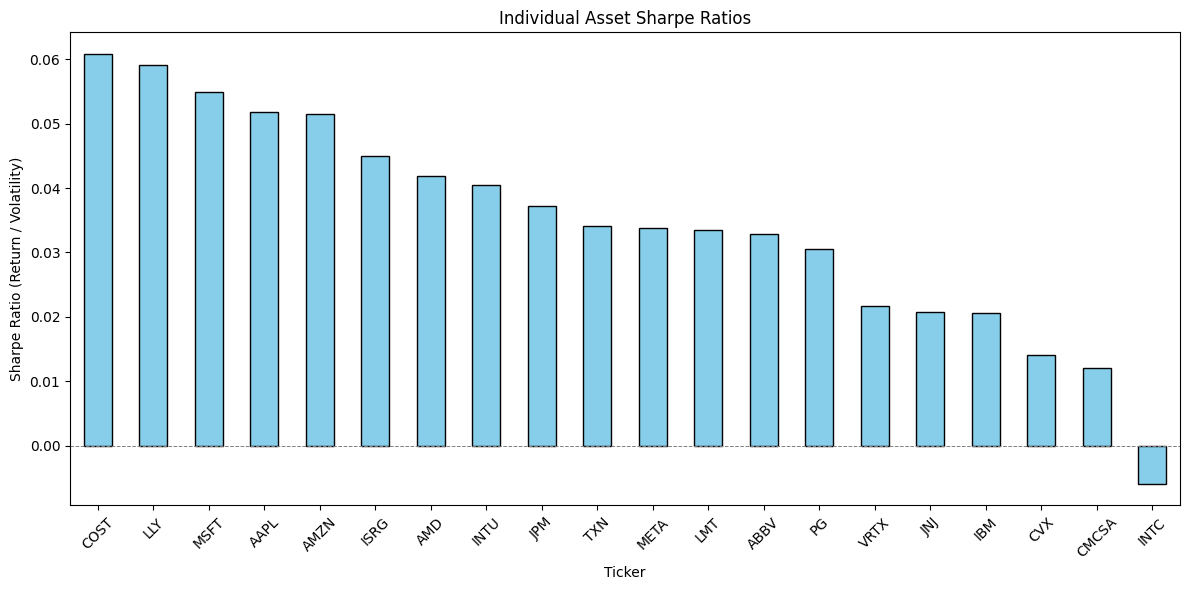

maximise sharpe ratio with non-convex formulation. Optimal Weights: [0.05778, 0.00225, 0.05639, 0.1293, 0.0, 0.34817, 0.0, 0.0, 0.0, 0.0, 0.00311, 0.0, 0.04148, 0.33759, 0.02201, 0.0, 0.00192, 0.0, 0.0, 0.0]
Resulting risk: 0.012076623100059544, return: 0.0009560612428086096


In [11]:
base_weights, base_returns, base_risk = maximise_sharpe_ratio(my_returns, convex=False, plotting=True)

We can also solve the convex formulation for the maximal risk calculated via the non-convex problem - this should yield the approximately the same results

In [12]:
base_weights_convex = maximise_sharpe_ratio(my_returns, convex=True, max_risk=base_risk)
# Create a DataFrame to display the weights nicely
weights_df = pd.DataFrame({
    "Asset": my_assets,
    "Non-Convex Weights": base_weights,
    "Convex Weights": base_weights_convex
})

# Print the DataFrame
print(weights_df)
assert np.allclose(base_weights, base_weights_convex, atol=1e-2), "Weights from convex and non-convex methods do not match!"

maximise sharpe ratio with convex formulation and fixed maximum risk of 0.012076623100059544. Optimal Weights: 0.05782, 0.00211, 0.05638, 0.12936, 0.00000, 0.34828, 0.00000, 0.00000, 0.00000, 0.00000, 0.00303, 0.00000, 0.04152, 0.33766, 0.02209, 0.00000, 0.00173, 0.00000, 0.00000, 0.00000
    Asset  Non-Convex Weights  Convex Weights
0   CMCSA        5.777872e-02    5.782040e-02
1    MSFT        2.250220e-03    2.111933e-03
2     AMD        5.639313e-02    5.638233e-02
3     JPM        1.292961e-01    1.293647e-01
4    INTU        6.679928e-08    7.965099e-07
5     LLY        3.481736e-01    3.482764e-01
6    COST        1.001664e-07    1.142076e-06
7     CVX        1.058347e-07    1.198813e-06
8      PG        1.919431e-08    3.051288e-07
9    VRTX        1.509747e-07    1.685993e-06
10   META        3.109913e-03    3.030140e-03
11   AAPL        1.292938e-07    1.433612e-06
12   ABBV        4.147985e-02    4.152364e-02
13    JNJ        3.375944e-01    3.376609e-01
14   INTC        2.2

It may be that a few assets dominate the portfolio. This can be the case depending on how the Sharpe ratios for induvidual assets are distributed (can be seen if option ``plotting=True``). For example if,
1. One or two bars are much higher than others: Those assets will dominate dominate and have high weights.
2. All bars are close to each other: The optimiser may be unstable and nearly all weights may be ~the same.
3. Some bars are negative: Corresponding weights will be zero ( due to optimisation constraint ``w >= 0``).

To ensure some level of diversification we can impose a maximum weight to the portfolio. For example, here are the results with a maximum weight of 0.25 applied.

If there is a good spread of Sharpe ratio throughout induvidual assets, we should not expect to see large differences in portfolio weights.

In [13]:
base_weights, base_returns, base_risk = maximise_sharpe_ratio(my_returns, convex=False, max_weight=0.25)

# add this to the weights_df
weights_df["Non-Convex Weights (Max 0.25)"] = base_weights
# Print the DataFrame
print(weights_df)

maximise sharpe ratio with non-convex formulation. Optimal Weights: [0.06669, 0.02111, 0.05516, 0.13581, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.00936, 0.0, 0.04613, 0.3, 0.0508, 0.0, 0.01494, 0.0, 0.0, 0.0]
Resulting risk: 0.011847085119874269, return: 0.0009353913296067411
    Asset  Non-Convex Weights  Convex Weights  Non-Convex Weights (Max 0.25)
0   CMCSA        5.777872e-02    5.782040e-02                   6.669040e-02
1    MSFT        2.250220e-03    2.111933e-03                   2.110764e-02
2     AMD        5.639313e-02    5.638233e-02                   5.515996e-02
3     JPM        1.292961e-01    1.293647e-01                   1.358138e-01
4    INTU        6.679928e-08    7.965099e-07                   6.887425e-08
5     LLY        3.481736e-01    3.482764e-01                   2.999995e-01
6    COST        1.001664e-07    1.142076e-06                   9.928090e-08
7     CVX        1.058347e-07    1.198813e-06                   1.100500e-07
8      PG        1.919431e-08    3.0512

## 3. Scenario Generation: Apply shocks

To simulate uncertainty in markets we can apply shocks to asset returns and alter the covariance matrix.

here we define shocks per asset class, and apply a simple transformation uniformly upon the covariance matrix. While this behaviour is artificial, it allows us to 
1. Assess the expected performace of our base portfolio under these shocks,
2. Re-caluculate the optimal portfolio in the shocked scenario

In the dictionary ``sector_shocks`` we can describe a shock scenario.

In [14]:
sector_shocks = {
    "Technology": -0.15,              # Tech crash (e.g., interest rate shock)
    "Energy": +0.10,                  # Oil price spike
    "Financial Services": -0.08,      # Banking panic
    "Healthcare": -0.05,              # Regulatory changes / drug failures
    "Consumer Cyclical": -0.12,       # Recession hits discretionary spending
    "Consumer Defensive": +0.02,      # Safe haven during downturn
    "Industrials": -0.07,             # Supply chain shocks
    "Basic Materials": -0.10,         # Commodity demand drop
    "Utilities": +0.03,               # Flight to defensive yield
    "Communication Services": -0.10,  # Ad revenue collapse or tech overlap
    "Real Estate": -0.12,             # CRE crash / interest rate stress
}

We can also generate sector shocks dynamically. For, we can draw sector shocks from a normal distribution with mean 0 and standard deviation 0.1.

That means:
* Some sectors will gain expected return
* Others will lose

We will impose a limit on shocks of +/-0.15 such that markets are not too volatile.

>**Note**: This is not a realistic generation of scenarios.

Most of the time, the impact will be negative overall for the original portfolio, unless the base portfolio was already tilted toward the positively shocked sectors

In [15]:
for sector in sector_shocks.keys():
    sector_shocks[sector] = random.gauss(0, 0.1)
    # force shock between -0.15 and +0.15
    sector_shocks[sector] = max(-0.15, min(0.15, sector_shocks[sector]))
print(sector_shocks)

{'Technology': 0.04372871875380623, 'Energy': -0.0677474560250339, 'Financial Services': -0.15, 'Healthcare': 0.020042827239471317, 'Consumer Cyclical': 0.078954675092905, 'Consumer Defensive': 0.09821848784926684, 'Industrials': 0.0008733146317177636, 'Basic Materials': -0.1276165583897065, 'Utilities': 0.06418473327473383, 'Communication Services': -0.022024598550799256, 'Real Estate': -0.048027612292602134}


We can analyse how well our base portfolio behaves under the shock. We can apply a constant scaling factor of 1.1 to the covariance matrix.

In [16]:
my_cov_scale = 1.1
shocked_mu, shocked_cov = apply_shock(my_assets, my_returns.mean(), my_returns.cov(), sector_shocks,
                                      cov_scale=my_cov_scale)

def evaluate_portfolio(w, mu, cov):
    """Evaluate the portfolio given weights, mean returns, and covariance matrix."""
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w, cov @ w))
    return ret, vol, ret / vol

shocked_base_returns, _, _ = evaluate_portfolio(base_weights, shocked_mu, shocked_cov)
print(f"Expected returns of the optimised base portfolio under shocks:{shocked_base_returns}"
      f" vs. {base_returns} without shocks.")

Expected returns of the optimised base portfolio under shocks:0.04685478488796574 vs. 0.0009353913296067411 without shocks.


It is most likely that the portfolio performed worse. In these cases it is interesting to compare which asset weights result in optimal Sharpe Ratio under the schocked scenario.

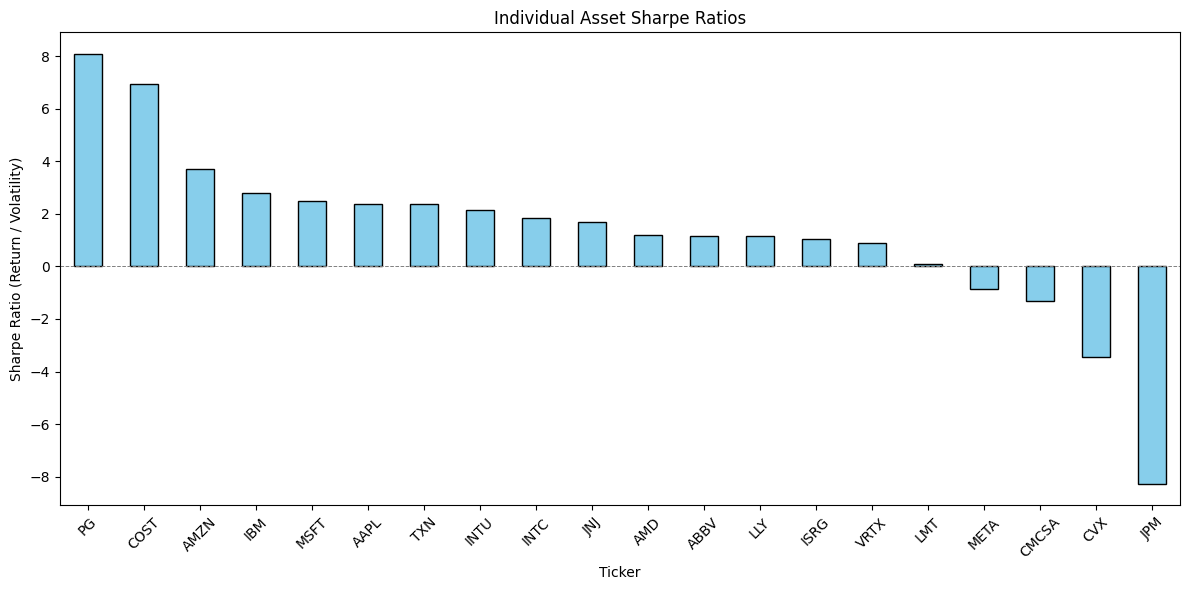

maximise sharpe ratio with non-convex formulation. Optimal Weights: [-0.0, 0.00541, -0.0, 0.17855, -0.0, 0.3, -0.0, 0.14902, -0.0, -0.0, -0.0, 0.06702, -0.0, -0.0, -0.0, -0.0, -0.0, 0.3, -0.0, -0.0]
Resulting risk: 0.0108000615307429, return: 0.0816062571575704
Base weights: [6.66904024e-02 2.11076421e-02 5.51599617e-02 1.35813834e-01
 6.88742528e-08 2.99999456e-01 9.92809045e-08 1.10049994e-07
 1.87472964e-08 1.53349868e-07 9.36108107e-03 1.46579878e-07
 4.61268470e-02 2.99999564e-01 5.07954447e-02 1.58308413e-07
 1.49443643e-02 4.32491833e-07 1.20141225e-07 9.48966766e-08]
Optimised shock scenario weights: [-7.90233136e-09  5.41332975e-03 -9.27674553e-09  1.78546619e-01
 -9.50352885e-09  3.00000009e-01 -9.70639840e-09  1.49018975e-01
 -8.38670990e-09 -8.77011325e-09 -9.17903206e-09  6.70211774e-02
 -9.85386529e-09 -5.92346048e-09 -8.39898429e-09 -9.67880155e-09
 -8.59092282e-09  3.00000010e-01 -6.76957808e-09 -8.35704561e-09]
Base risk: 0.011847085119874269
Optimised shock scenario r

In [17]:
shock_weights, shock_returns, shock_risk = maximise_sharpe_ratio(my_returns, convex=False, max_weight=0.25,
                                   tickers=my_assets,
                                   sector_shocks=sector_shocks,
                                   cov_scale=my_cov_scale,
                                   plotting=True)

print("Base weights:", base_weights)
print("Optimised shock scenario weights:", shock_weights)
print("Base risk:", base_risk)
print("Optimised shock scenario risk:", shock_risk)
print("Base returns:", base_returns)
print("Optimised shock scenario returns:", shock_returns)

In [18]:
# Generate n_scenarios of shocks
n_scenarios = 10
scenarios = []
for _ in range(n_scenarios):
    scenario = {}
    for sector in sector_shocks.keys():
        scenario[sector] = random.gauss(0, 0.1)
        # force shock between -0.15 and +0.15
        scenario[sector] = max(-0.15, min(0.15, scenario[sector]))
    scenarios.append(scenario)

Robust optimisation: First take an approach where we optimise each scenario separately and take the robust portfolio to consist of assets where weights are determined by averages of weights.

In [19]:
# optimize the portfolio such that it is robust to the shocks
robust_weights = []
for scenario in scenarios:
    weights, _, _ = maximise_sharpe_ratio(my_returns, convex=False, max_weight=0.25,
                                          tickers=my_assets,
                                          sector_shocks=scenario,
                                          cov_scale=my_cov_scale)
    robust_weights.append(weights)

# Calculate the average weights across all scenarios
robust_weights = np.mean(robust_weights, axis=0)
# check if the weights sum to 1
assert np.isclose(np.sum(robust_weights), 1), "Robust weights do not sum to 1."
print("Robust weights:", robust_weights)
# Print the DataFrame with robust weights
weights_df["Robust Weights"] = robust_weights
print(weights_df)

maximise sharpe ratio with non-convex formulation. Optimal Weights: [-0.0, 0.05442, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.3, 0.3, 0.08297, 0.2594, -0.0, -0.0, -0.0, -0.0, 0.00322]
Resulting risk: 0.011257919414284799, return: 0.06691054101152226
maximise sharpe ratio with non-convex formulation. Optimal Weights: [0.02327, -0.0, -0.0, 0.27059, -0.0, -0.0, -0.0, 0.29949, -0.0, -0.0, -0.0, 0.05557, -0.0, -0.0, 0.3, -0.0, -0.0, -0.0, 0.05108, -0.0]
Resulting risk: 0.012112230142648247, return: 0.08364526902350607
maximise sharpe ratio with non-convex formulation. Optimal Weights: [0.14782, -0.0, -0.0, -0.0, -0.0, -0.0, 0.3, 0.3, -0.0, 0.01401, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.16944, -0.0, 0.06872, -0.0]
Resulting risk: 0.01363324986604247, return: 0.06829861109050138
maximise sharpe ratio with non-convex formulation. Optimal Weights: [0.13571, -0.0, -0.0, -0.0, 0.17415, -0.0, 0.16766, 0.3, -0.0, 0.00139, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.15361, -0.0, 0.06747, -0.0

In [20]:
print(f"The sum of the robust weights is: {np.sum(robust_weights)}")

The sum of the robust weights is: 1.0000000000000002


We can run a Monte Carlo simulation to evaluate the robustness of the portfolio. For robust metrics a high number of simulations should be run (~10,000). Here, we keep the number small to limit run times but high enough to generate clean visuals. To facilitate higher run numbers, the functions used can be vectorised.

In [21]:
from tqdm import tqdm

# Use a Monte Carlo simulation to evaluate the robustness of the portfolio
n_simulations = 100
simulated_returns = []
for _ in tqdm(range(n_simulations), desc="Simulating"):
    # Generate random shocks for each sector
    random_shocks = {sector: random.gauss(0, 0.1) for sector in sector_shocks.keys()}
    # Apply the shocks to the mean and covariance
    sim_mu, sim_cov = apply_shock(my_assets, my_returns.mean(), my_returns.cov(), random_shocks,
                                  cov_scale=my_cov_scale)
    # Evaluate the portfolio
    ret, vol, sharpe = evaluate_portfolio(robust_weights, sim_mu, sim_cov)
    simulated_returns.append((ret, vol, sharpe))


Simulating: 100%|██████████| 100/100 [07:28<00:00,  4.48s/it]


Mean Return: 0.0014
Mean Volatility: 0.0111
Mean Sharpe Ratio: 0.1298
95% Confidence Interval for Return: (-0.0740, 0.0787)


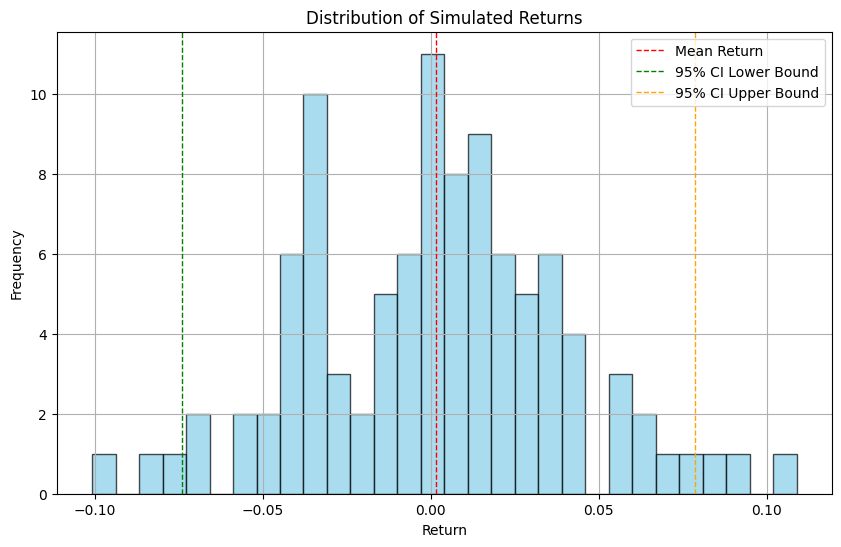

In [22]:
# Convert to DataFrame for easier analysis
simulated_df = pd.DataFrame(simulated_returns, columns=["Return", "Volatility", "Sharpe"])
# Calculate statistics
mean_return = simulated_df["Return"].mean()
mean_volatility = simulated_df["Volatility"].mean()
mean_sharpe = simulated_df["Sharpe"].mean()
# Calculate the 95% confidence intervals
lower_bound = simulated_df["Return"].quantile(0.025)
upper_bound = simulated_df["Return"].quantile(0.975)
# Print the results
print(f"Mean Return: {mean_return:.4f}")
print(f"Mean Volatility: {mean_volatility:.4f}")
print(f"Mean Sharpe Ratio: {mean_sharpe:.4f}")
print(f"95% Confidence Interval for Return: ({lower_bound:.4f}, {upper_bound:.4f})")
# Plot the distribution of simulated returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_df["Return"], bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(mean_return, color='red', linestyle='dashed', linewidth=1, label='Mean Return')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=1, label='95% CI Lower Bound')
plt.axvline(upper_bound, color='orange', linestyle='dashed', linewidth=1, label='95% CI Upper Bound')
plt.title("Distribution of Simulated Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

In this Monte Carlo simulation, we modeled the distribution of portfolio returns based on the Sharpe ratio optimization approach. The histogram provides a visual representation of the simulated returns, offering insight into the portfolio's risk and return characteristics.

Key findings include:

* Mean Return: The red dashed line indicates the expected mean return of the portfolio. This is the return we would anticipate under typical conditions.

* 95% Confidence Interval: The green and orange dashed lines denote the 95% confidence interval bounds, capturing the range within which we expect most simulated returns to fall. This helps quantify the uncertainty associated with the portfolio's return potential.

* Risk Profile: The distribution of returns reveals a fat left tail, suggesting a higher frequency of large negative returns compared to what would be expected under a normal distribution. This indicates the presence of increased downside risk in the portfolio. While most of the simulated returns are close to the mean, the possibility of extreme losses exists, highlighting the importance of risk management strategies to mitigate such potential negative outcomes.

* Non-normal Distribution: The presence of a fat left tail also suggests that the return distribution is not perfectly normal, with a higher probability of significant negative returns. This is a crucial consideration for assessing the robustness of the portfolio and ensuring that risk measures such as the Sharpe ratio accurately reflect the portfolio's true risk profile.